<h1> Семантическая сегментация, детекция.

Скачаем и разархивируем заранее все данные, которые нам понадобятся и установим недостающий модуль

In [ ]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip  # Carvana dataset
!wget https://www.dropbox.com/s/k886cusbuc1afnq/imagenet-mini.zip  # mini image-net dataset
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt  # классы имаджнета
!unzip -q CARVANA.zip
!unzip -q imagenet-mini.zip
!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!pip install colour

In [ ]:
!ls -l

<h2>Часть 1. Семантическая сегментация

In [1]:
import os
import warnings
from os.path import isfile, join
from typing import Dict, List, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from colour import Color
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm, trange

warnings.filterwarnings("ignore")

<h> Напишем свой U-net с нуля, обучим и попробуем его на задаче распознавания точной маски автомобиля

In [2]:
class Carvana(Dataset):
    def __init__(
        self,
        root: str,
        transform: transforms.Compose = None,
    ) -> None:
        """
        :param root: путь к папке с данными
        :param transform: transforms of the images and labels
        """
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path: str) -> List[str]:
            """
            Возвращает список с путями до всех изображений

            :param path: путь к папке с данными
            :return: лист с путями до всех изображений
            """
            images_dir = [
                join(path, f) for f in os.listdir(path) if isfile(join(path, f))
            ]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + "/train")
        self.labels_path = load_images(self.root + "/train_masks")

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param index: sample index
        :return: tuple (img, target) with the input data and its label
        """
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)


def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask

    :param img_list: list of paths to images
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])))
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

Загрузим датасет при помощи определенного выше класса

In [3]:
train_dataset = Carvana(
    root=".",
    transform=transforms.Compose(
        [transforms.Resize((256, 256)), transforms.ToTensor()]
    ),
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4
)

Посмотрим несколько примеров изображений и масок автомобиля

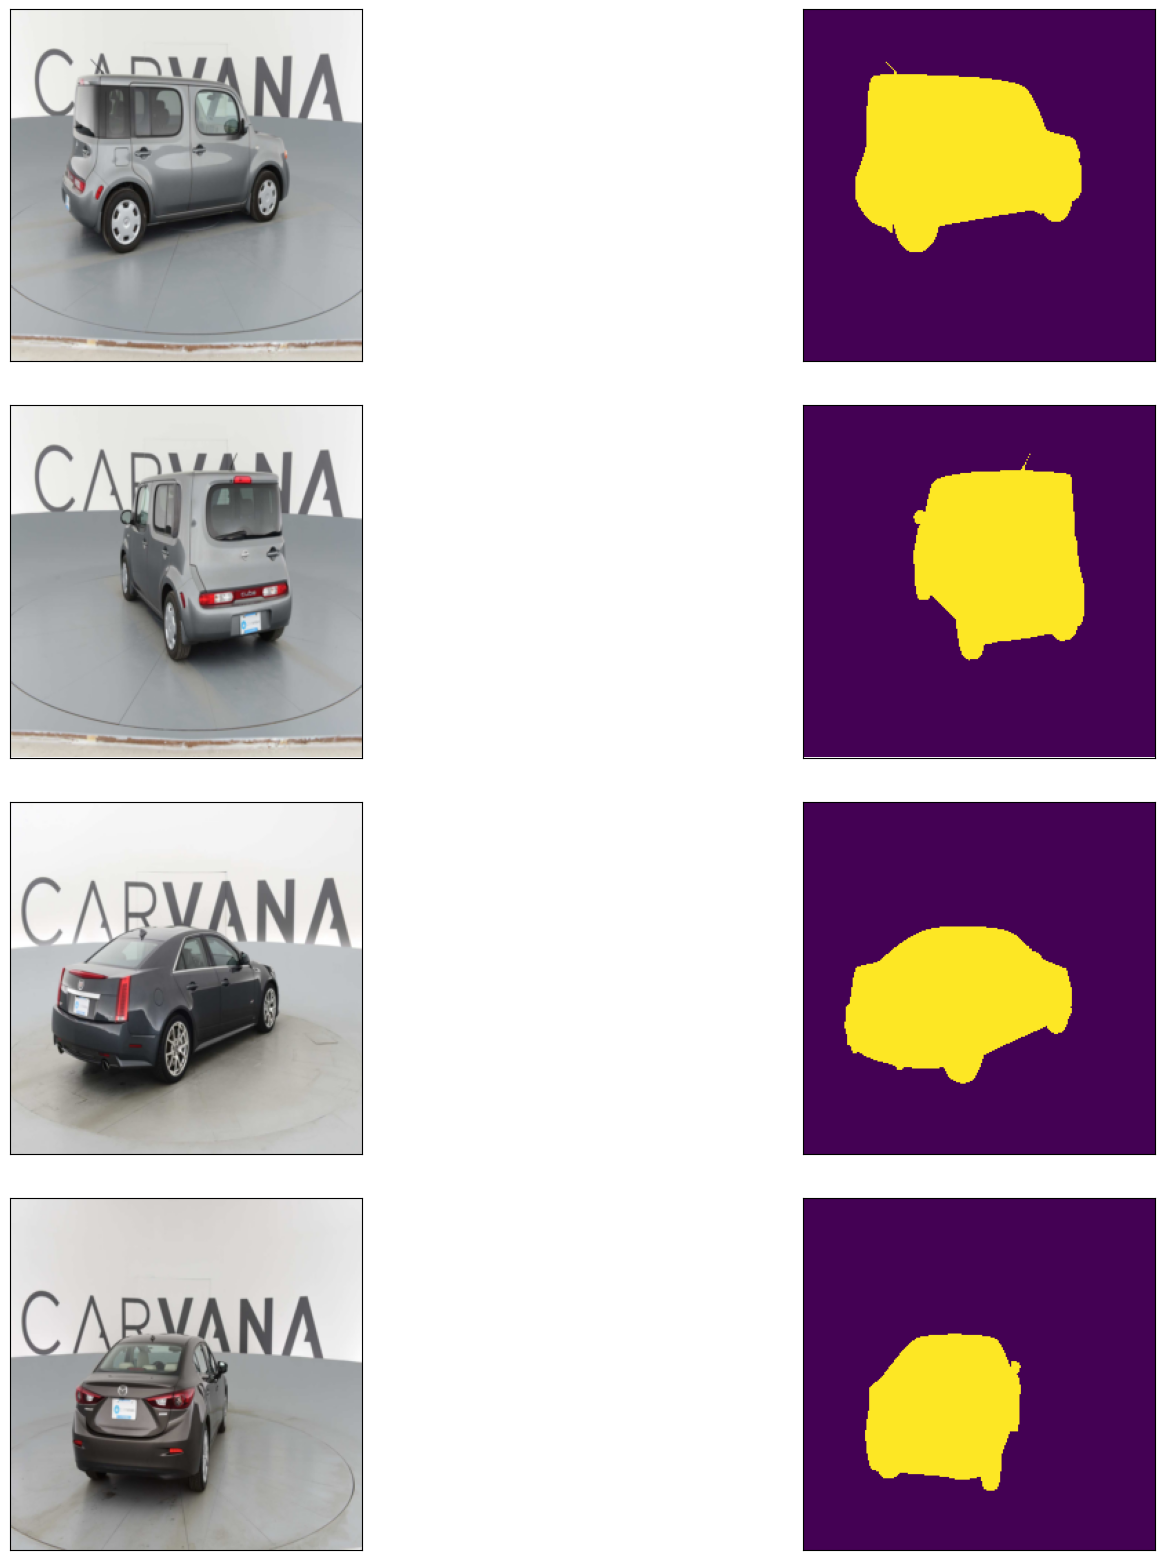

In [4]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append((img, label))

im_show(img_list)

Дополните недостающий код таким образом, чтобы получилась архитектура U-net сети (https://arxiv.org/pdf/1505.04597.pdf). 
Обратите внимание, что при проходе "вниз" количество каналов каждого блока __увеличивается в два раза__. 
Ситуация с проходом "вверх" противоположна, количество каналлов __уменьшается вдвое__. 
Также, начинаем мы __не с 64 каналов__, как на схеме ниже, __а с 16 каналов__. 

При проходе вниз в нашей реализации предлагается __дойти до 128 каналов__, чтобы сэкономить время обучения, в оригинальной статье было до 1024. (2 блока, вместо 4х)
В целом, при отличии количества каналлов от указанных выше чисел, модель все равно будет работать.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

Подсказка: каждый блок по пути "вниз" представляет из себя двойную свертку с батч нормом и активацией (при создании `Relu` слоя не забывайте `inplace=True`).

In [9]:
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv =  nn.Conv2d(in_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu =  nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = nn.Sequential(
            ConvBlock(3, 16),
            ConvBlock(16, 32)
        )

        self.down_2 =  nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 128)
        )

        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)

        self.up_2 =  nn.Sequential(
            ConvBlock(256, 128),# 128 каналов от down_2 и 128 middle
            ConvBlock(128, 64)
        )

        self.up_1 =  nn.Sequential(
            ConvBlock(96, 64), # 32 канала от down_1 и 64 от up_2
            ConvBlock(64, 32)
        )

        self.output = nn.Sequential(
            ConvBlock(32, 16),
            ConvBlock(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        down1 =  self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 =  self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)  # интерполяцией увеличиваем размер фильтра вдвое
        out = torch.cat([down2, out], dim=1)
        out = self.up_2(out)

        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)  # интерполяцией увеличиваем размер фильтра вдвое
        out = torch.cat([down1, out], dim=1)
        out = self.up_1(out)

        out = F.interpolate(out, scale_factor=2)
        return self.output(out)

Определяем функцию для обучения одной эпохи

In [5]:
def train(train_loader, model, criterion, epoch, num_epochs, device):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))

        loss = criterion(outputs, labels)

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(
            f"Loss: {round(loss.item(), 4)} "
            f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()

In [10]:
device = "cpu"
model = Unet().to(device)
criterion = (
    torch.nn.BCELoss()
)  # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.RMSprop(
    model.parameters(), weight_decay=1e-4, lr=1e-4, momentum=0.9
)

num_epochs = 1
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs, device=device)

  0%|          | 0/40 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 64 for tensor number 1 in the list.

Посмотрим на результаты

In [ ]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    pred = model(img.unsqueeze(0).cuda()).detach().squeeze(0).cpu()
    img_list.append((img, pred))

im_show(img_list)

Еще несколько эпох и никакие гринскрины нужны не будут...

In [ ]:
# освободим память
torch.cuda.empty_cache()

---

<h2>Часть 2. mean Average Precision

Для определения метрики mean Average Precision понадобится проделать небольшой путь и вспомнить пару понятий.

Вспомним базовые понятия точности и полноты:
<br>
$$ Precision = {TP \over TP + FP} $$
<br>
$$ Recall = {TP \over TP + FN} $$
<br>
<br>TP - True Positive
<br>FP - False Positive
<br>FN - False Negative
<br> <br> __Precision__ - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, среди всех объектов, названных классификатором положительными.

__Recall__ - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, среди всех истинно положительных объектов.

<h4>Intersection over Union</h4>
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>


В задаче детекции метки TP, FP, FN (чаще всего) выдаются по следующей логике:

- метка TP выдается в случае если IoU > 0.5 и класс определен правильно
- метка FP выдается в случае если IoU <= 0.5 и/или если Bounding Box'ы дублируются
- метка FN выдается если если IoU > 0.5, но неправильно определен класс и/или если бокса нет совсем

<h3> Чтобы было нагляднее: </h3>

* зеленый цвет - истинный бокс и класс
* синий - наши предсказания

<h4>True Positive </h4> У нас два волка, оба определены своим классом и боксы очевидно имеют IoU больше 0.5.
<img src="Практика07\TruePositiveVolks.jpg">

<h4>False Positive </h4> Несмотря на то, что класс определен правильно и бокс в целом выглядит логично на своем месте, IoU слишком мал, поэтому такая детекция получает метку FP.
<img src="Практика07\FalsePositiveVolk.jpg">

<h4>False Negative </h4> Потому что несмотря на хорошее пересечение предсказанного бокса с целевым, класс с высокой уверенностью определен неправильно.
<img src="Практика07\FalseNegativeVolk.jpg">

<h3> PR-кривая </h3>

Далее, для подсчёта mAP, нужно построить PR-кривую. 
Напомним, что это кривая, у которой по оси Y - значение Precision, а по оси X - значение recall. 
Эти значения считаются при переборе пороговых вероятностей, начиная с которых объект помечается положительным классом.

Для задачи бинарной классификации мы когда-то строили такую кривую, теперь рассмотрим чуть более сложный случай, где у нас три класса: Волк, Лев и Тигр + решается задача детекции, а не классификации.


Внизу представлена таблица с игрушечными данными по предсказаниям модели. 
Допустим из 7 объектов, в датасете у нас только 3 волка. 
В данном случае мы называли объект "действительно волком" если он имел правильный класс и IoU не менее 0.5. 
Таким образом имеем задачу вида one vs all, где интересующим нас классом будет являться именно "волк".

|Номер строки| Уверенность в том что волк (истинный класс)    |IoU не менее 0.5?   |  Precision  |  Recall |
|------------|------------------------|----------------------|-------------|---------| 
|1           |0.92 (Волк)     |   True    |    1.0     |    0.33 |
|2           |0.83 (Волк)     |   True    |    1.0     |    0.67 | 
|3           |0.77 (Волк)     |   False   |    0.67    |    0.67 | 
|4           |0.71 (Лев)      |   False   |    0.50    |    ...  |
|5           |0.67 (Тигр)     |   False   |    0.40    |    .... | 
|6           |0.54 (Волк)     |   True    |    0.50    |    .... | 
|7           |0.47 (Тигр)     |   False   |    0.50    |    1.0  |

<h6>Посчитаем Precision и Recall для порога в 0.9:</h6>
Здесь все легко, взяли порог в 0.9 и называем волками всех, у кого уверенность в классе "Волк" больше 0.9. Один TP, отсутсвуют FP и два FN (2 и 6 строчки). 
$$Precision ={  1 \over 1 + 0} = 1.0$$

$$Recall = {1 \over 1 + 2} = 0.33$$

<h6>для порога в 0.8:</h6> 
Здесь тоже без дополнительных сложностей. С таким порогом, во второй строчке у нас нашелся еще один TP, соотоветственно убавился один FN. Остальное осталось так же.
$$Precision ={  2 \over 2 + 0} = 1.0$$

$$Recall = {2 \over 2 + 1} = 0.67$$

<h6>для порога в 0.75:</h6>  
А вот при пороге в 0.75 в третьей строчке замечаем, что несмотря на то, что истинный класс действительно "Волк", чем мы и называем данный объект - IoU c истинным боксом меньше 0.5, поэтому присваиваем метку FP.
$$Precision ={  2 \over 2 + 1} = 0.67$$

$$Recall = {2 \over 2 + 1} = 0.67$$

<h6>Дальше сами :)</h6>
<h6>Задание: Посчитать недостающие в таблице значения precision и recall и сравнить с изображенной PR кривой</h6>

PR кривая будет вылядеть следуюшим образом:
<img src="Практика07\pr_uno.png">

<h3> Монотонная PR-кривая </h3>

**Average Precision (AP)** стандартно **определяется как AUC-PR**, то есть как площадь по PR кривой. Из-за того, что Precision и Recall находятся в отрезке от 0 до 1, AP так же определена на этом отрезке. Чем ближе к 1, тем качественнее модель.

Для удобства вычислений, и чуть большей устойчивости к перестановке - вместо того, чтобы терпеть возникшую немонотонность, для всех совпадающих значений recall'a берется максимальный справа от текущей точки precision, то есть график изменится следующим образом:

<img src="Практика07\pr_dos.png">

Технология та же - для вычисления AP считается AUC под красной кривой:

$$AP = 1 * 0.67 + (1 - 0.67) * 0.5 = 0.835 $$

<h3>k-point interpolation</h3>

В какой-то момент люди решили, что просто площади теперь не круто и в популярном соревновании PASCAL VOC2008 для вычисления Average Precision использовалась 11-point interpolation. 

По-простому: брались 11 значений монотонной PR функции, в точках 0, 0.1, 0.2, ..., 0.9, 1.0 и усреднялись. <br>Для любителей формул:

$$AP = {1 \over11} * \sum P(r), r \in [0.1, 0.2, ..., 0.9, 1.0]$$
$P(r)$ - значение Precision при определенном Recall.

Графически это все выглядит следующим образом:

<img src="Практика07\pr_tres.png">

Посчитаем АР данным способом:
$$AP = {1 \over {11}} (1 * 7 + 3 * 0.5) = 0.77$$

<h3>Подсчёт mAP</h3>

Для более <font color="green">свежего </font> PASCAl VOC соревнований (2011 - 2012) было принято решение считать **Average Precision** как обычную __площадь под монотонной PR кривой__. Этого определения мы и будем придерживаться далее.

Все предыдущие графики, наша первая табличка и значения AP считались для одного класса "Волк". Понятно, что подобные значения можно посчитать для каждого класса в выборке. И каждый раз будет принцип one vs all, где различается нужный класс и "все остальные"


Метрика __mean Average Precison__ считается как среднее между __AP__ каждого класса, те:

$$mAP = \sum_{c \in C} AP(c)$$
где С - множество классов.

<br>Ниже - пример того как считать среднее :))

*для Average Precision льва и тигра значения взяты случайно

|AP(Волк)| AP(Лев) | AP(Тигр)|mAp    |
|--------|---------|---------|-------|
|0.835   |0.83     | 0.77    | 0.81  |

---

<h2>Часть 3. Детекция объектов на изображениях</h2>

Далее попробуем обучить модель детекции. 
Мы не будем полностью реализовывать архитектуру сети, а возьмем предобученную Faster R-CNN из pytorch и сделаем fine-tuning.

Для начала загрузим данные. Мы будем пользоваться датасетом [Penn-Fudan](https://www.cis.upenn.edu/~jshi/ped_html/). Он содержит 170 изображений с разметкой сегментации и детекции. Мы воспользуемся последней

In [ ]:
! curl https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip > PennFudanPed.zip
! unzip -q PennFudanPed.zip

In [ ]:
from PIL import ImageDraw
from sklearn.metrics import auc
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transforms_list: transforms = None):
        self.root = root
        self.transforms = transforms_list
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {"boxes": boxes, "labels": labels, "image_id": image_id}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train=False):
    transforms_list = []
    if train:
        transforms.append(transforms.RandomHorizontalFlip(0.5))
    transforms_list.append(transforms.ToTensor())

    return transforms.Compose(transforms_list)

In [ ]:
dataset = PennFudanDataset("PennFudanPed/", get_transform())

In [ ]:
image, labels = next(iter(dataset))
image = transforms.ToPILImage()(image)

draw = ImageDraw.Draw(image)
for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

image

Теперь подгрузим модель. Среди моделей детекции в pytorch есть только `Faster R-CNN`. Так как мы детектим только 2 класса - пешеходов и фон, нужно изменить выходной слой, предсказывающий классы изображений. Для этого в torchvision есть блок `FastRCNNPredictor`.

<h4>Схема модели Fast R-CNN</h4>
<img src=https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png>

In [ ]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Теперь давайте напишем подсчет IoU, которая пригодится нам для отбора кандидатов.

<h4>Intersection over Union </h4>
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>

In [ ]:
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Intersection over Union between two bboxes
    (x0, y0) - coordinates of the upper left bbox corner
    (x1, y1) - coordinates of the down right bbox corner

    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # <your code here>

In [ ]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

In [ ]:
def evaluate_sample(target_pred: torch.Tensor, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # предсказания модели
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5
            detection_result_dict["TP"] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    global_loss = 0
    for images, targets in tqdm(data_loader, leave=False, desc="Batch number"):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        global_loss += float(losses.cpu().detach().numpy())

    return global_loss


def train(model, train_loader, test_loader, optimizer, device, num_epochs=5):
    for epoch in trange(num_epochs, leave=True, desc=f"Epoch number"):
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)

        print(f"mAP after epoch {epoch + 1} is {mAP:.3f}")

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


dataset = PennFudanDataset("PennFudanPed", get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()

dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    collate_fn=collate_fn,
)

dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn
)

In [ ]:
num_classes = 2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train(model, data_loader_train, data_loader_test, optimizer, device)

Давайте посмотрим, как наша модель научилась выделять людей

In [ ]:
image, labels = next(iter(dataset_test))
model.eval()
pred = model(image.unsqueeze(0).to(device))[0]

image = transforms.ToPILImage()(image)

draw = ImageDraw.Draw(image)

for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in pred["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red")

image

In [ ]:
pred

In [ ]:
for l_box in labels["boxes"]:
    print(
        intersection_over_union(pred["boxes"][0].cpu().detach().numpy(), l_box.numpy())
    )